In [127]:
# !pip install feature_engine

In [128]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import pickle
from colorama import Back, Fore, Style
from feature_engine.encoding import WoEEncoder
from scipy.stats import rankdata
from sklearn.impute import KNNImputer
from sklearn.linear_model import (HuberRegressor, LinearRegression,
                                  LogisticRegression)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

warnings.filterwarnings('ignore')

In [129]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [130]:
def preprocessing(df_train, df_test):
    data = pd.concat([df_train, df_test])
    
    data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
    data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
    data['area'] = data['attribute_2'] * data['attribute_3']
    data['loading'] = np.log(data['loading'])

    full_fill_dict = {
        'A': ['measurement_5','measurement_6','measurement_8'],
        'B': ['measurement_4','measurement_5','measurement_7'],
        'C': ['measurement_5','measurement_7','measurement_8','measurement_9'],
        'D': ['measurement_5','measurement_6','measurement_7','measurement_8'],
        'E': ['measurement_4','measurement_5','measurement_6','measurement_8'],
        'F': ['measurement_4','measurement_5','measurement_6','measurement_7'],
        'G': ['measurement_4','measurement_6','measurement_8','measurement_9'],
        'H': ['measurement_4','measurement_5','measurement_7','measurement_8','measurement_9'],
        'I': ['measurement_3','measurement_7','measurement_8']
    }

    features = [f for f in test.columns if 'measurement' in f] + ['loading']
    for code in data.product_code.unique():
        tmp = data[data.product_code==code]
        column = full_fill_dict[code]
        tmp_train = tmp[column+['measurement_17']].dropna(how='any')
        tmp_test = tmp[(tmp[column].isnull().sum(axis=1)==0)&(tmp['measurement_17'].isnull())]
        print(f"code {code} has {len(tmp_test)} samples to fill nan")
        model = HuberRegressor()
        model.fit(tmp_train[column], tmp_train['measurement_17'])
        data.loc[(data.product_code==code)&(data[column].isnull().sum(axis=1)==0)&(data['measurement_17'].isnull()), 'measurement_17'] = model.predict(tmp_test[column])
        model2 = KNNImputer(n_neighbors=5)
        print(f"KNN imputing code {code}")
        data.loc[data.product_code==code, features] = model2.fit_transform(data.loc[data.product_code==code, features])
    
    data['measurement_avg'] = data[[f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
    
    df_train = data.iloc[:df_train.shape[0], :]
    df_test = data.iloc[df_train.shape[0]:, :]
    
    woe_encoder = WoEEncoder(variables=['attribute_0'])
    woe_encoder.fit(df_train, df_train['failure'])
    df_train = woe_encoder.transform(df_train)
    df_test = woe_encoder.transform(df_test)

    return df_train, df_test

df_train, df_test = preprocessing(train, test)

code A has 386 samples to fill nan
KNN imputing code A
code B has 418 samples to fill nan
KNN imputing code B
code C has 391 samples to fill nan
KNN imputing code C
code D has 398 samples to fill nan
KNN imputing code D
code E has 429 samples to fill nan
KNN imputing code E
code F has 420 samples to fill nan
KNN imputing code F
code G has 373 samples to fill nan
KNN imputing code G
code H has 361 samples to fill nan
KNN imputing code H
code I has 377 samples to fill nan
KNN imputing code I


In [131]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               26570 non-null  int64  
 1   product_code     26570 non-null  object 
 2   loading          26570 non-null  float64
 3   attribute_0      26570 non-null  float64
 4   attribute_1      26570 non-null  object 
 5   attribute_2      26570 non-null  int64  
 6   attribute_3      26570 non-null  int64  
 7   measurement_0    26570 non-null  float64
 8   measurement_1    26570 non-null  float64
 9   measurement_2    26570 non-null  float64
 10  measurement_3    26570 non-null  float64
 11  measurement_4    26570 non-null  float64
 12  measurement_5    26570 non-null  float64
 13  measurement_6    26570 non-null  float64
 14  measurement_7    26570 non-null  float64
 15  measurement_8    26570 non-null  float64
 16  measurement_9    26570 non-null  float64
 17  measurement_

In [132]:
columns = df_train.columns[0:3].append(df_train.columns[7:30])
columns

Index(['id', 'product_code', 'loading', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure', 'm3_missing', 'm5_missing', 'area', 'measurement_avg'],
      dtype='object')

In [133]:
def _scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
    
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    
    #back to dataframe
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    
    assert len(train_data) == len(new_train)
    assert len(val_data) == len(new_val)
    assert len(test_data) == len(new_test)
    
    return new_train, new_val, new_test

In [134]:
df_train = df_train[df_train.failure.notnull()]
df_test = df_test[df_test.failure.isnull()]
print(df_train.shape, df_test.shape)

(26570, 30) (20775, 30)


In [135]:
X = df_train.drop(['failure'], axis=1)
y = df_train.failure

In [136]:
def save_fig(x_train, importance_list, features, clf_k):
    importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[features].columns)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = x_train[features].columns
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(20)
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title(f'LR Clf {clf_k} feature importances')
    plt.tight_layout()
    plt.savefig(f'LR Clf {clf_k} Feature Importance')
    plt.show()

In [137]:
select_features = {
    0: ['loading', 'measurement_17', 'area', 'm5_missing', 'm3_missing', 'attribute_0'],
    1: ['loading', 'measurement_17', 'area', 'attribute_0'],
    2: ['loading', 'measurement_17', 'area', 'm3_missing', 'm5_missing'],
    3: ['loading', 'measurement_17', 'measurement_4']
}

############## Classifier 0 #################
########################## 0 ##########################
########################## 1 ##########################
########################## 2 ##########################
########################## 3 ##########################
########################## 4 ##########################
Average auc = 0.59071, Average acc = 0.78739
OOF auc = 0.59066, OOF acc = 0.78739
############# End of Classifier 0 #############


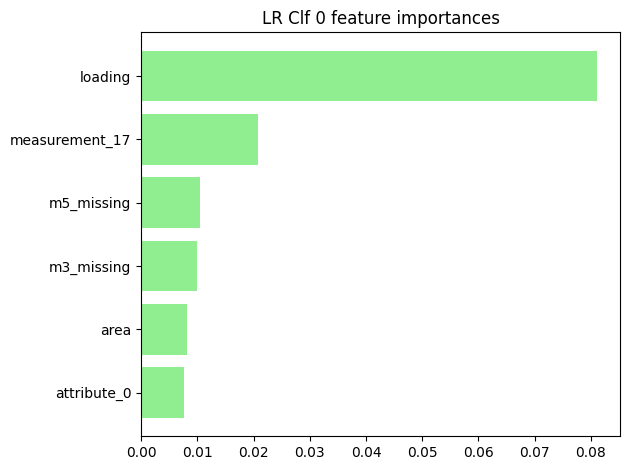

############## Classifier 1 #################
########################## 0 ##########################
########################## 1 ##########################
########################## 2 ##########################
########################## 3 ##########################
########################## 4 ##########################
Average auc = 0.58998, Average acc = 0.78739
OOF auc = 0.58993, OOF acc = 0.78739
############# End of Classifier 1 #############


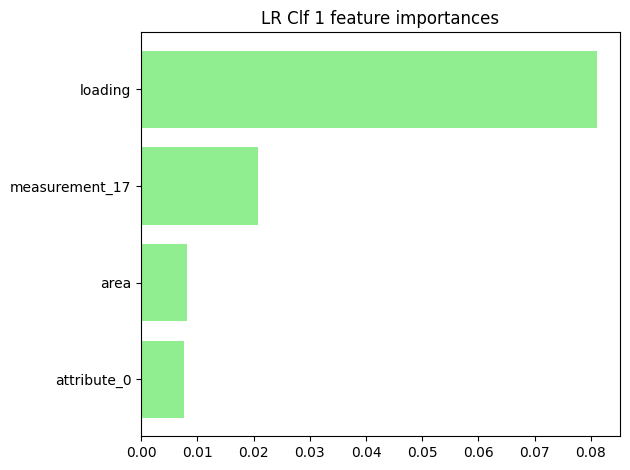

############## Classifier 2 #################
########################## 0 ##########################
########################## 1 ##########################
########################## 2 ##########################
########################## 3 ##########################
########################## 4 ##########################
Average auc = 0.59078, Average acc = 0.78739
OOF auc = 0.59077, OOF acc = 0.78739
############# End of Classifier 2 #############


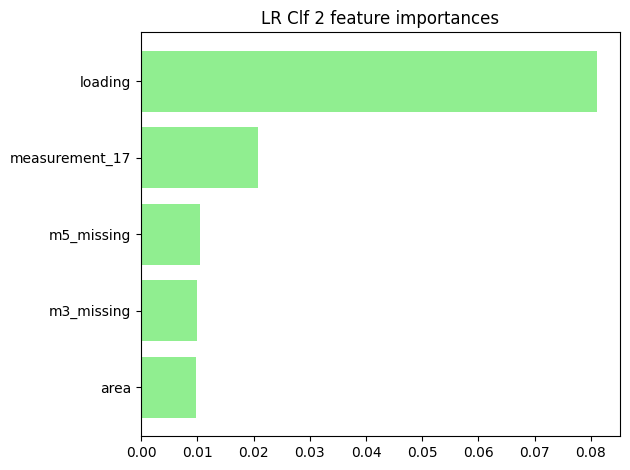

############## Classifier 3 #################
########################## 0 ##########################
########################## 1 ##########################
########################## 2 ##########################
########################## 3 ##########################
########################## 4 ##########################
Average auc = 0.59048, Average acc = 0.78739
OOF auc = 0.5904, OOF acc = 0.78739
############# End of Classifier 3 #############


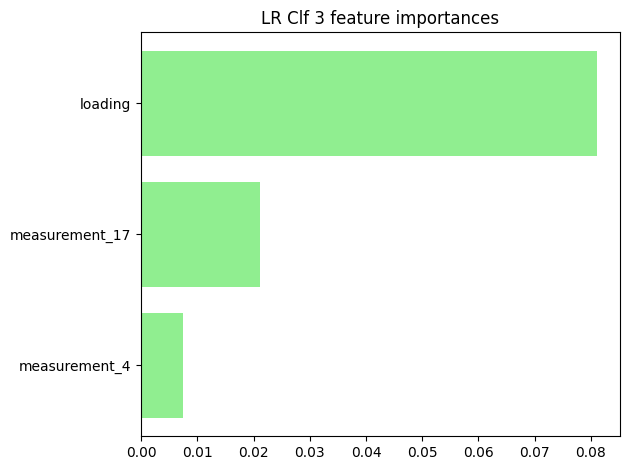

In [138]:
#kf = GroupKFold(n_splits=5)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
models = []
for clf_k in range(4):
    lr_oof_1 = np.zeros(len(train))
    lr_oof_2 = np.zeros(len(train))
    lr_test = np.zeros(len(test))
    lr_auc = 0
    lr_acc = 0
    importance_list = []
    features = select_features[clf_k]
    print(f'############## Classifier {clf_k} #################')
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f'########################## {fold_idx} ##########################')
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        x_test = df_test.copy()
    
        x_train, x_val, x_test = _scale(x_train, x_val, x_test, features)
        model = LogisticRegression(max_iter=1000, C=0.0001, dual=False, penalty="l2", solver='newton-cg')
        model.fit(x_train[features], y_train)
        importance_list.append(model.coef_.ravel())

        predictions = model.predict_proba(x_val[features])[:, 1]
        lr_auc += roc_auc_score(y_val, predictions) / 5
    
        y_preds = model.predict(x_val[features])
        lr_acc += accuracy_score(y_val, y_preds) / 5
    
        lr_test += model.predict_proba(x_test[features])[:, -1] / 5
        lr_oof_1[val_idx] = predictions
        lr_oof_2[val_idx] = y_preds
    models.append(model)
    print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}, Average acc = {round(lr_acc, 5)}{Style.RESET_ALL}")
    print(f"{Fore.RED}{Style.BRIGHT}OOF auc = {round(roc_auc_score(df_train['failure'], lr_oof_1), 5)}, OOF acc = {round(accuracy_score(df_train['failure'], lr_oof_2), 5)}{Style.RESET_ALL}")
    print(f'############# End of Classifier {clf_k} #############')
    
    submission[f'lr{clf_k}'] = lr_test
    save_fig(x_train=x_train, importance_list=importance_list, features=features, clf_k=clf_k)
    

In [139]:
submission['rank0'] = rankdata(submission['lr0'])
submission['rank1'] = rankdata(submission['lr1'])
submission['rank2'] = rankdata(submission['lr2'])
submission['rank3'] = rankdata(submission['lr3'])

In [140]:
submission['failure'] = submission['rank0']*0.2 + submission['rank1']*0.25 + submission['rank2']*0.25 + submission['rank3']*0.3

In [141]:
submission.head()

,id,failure,lr0,lr1,lr2,lr3,rank0,rank1,rank2,rank3
0,26570,10063.40,0.209881,0.209970,0.213093,0.211275,9698.0,9715.0,10983.0,9831.0
1,26571,6829.00,0.204818,0.204905,0.207972,0.203990,6870.0,6846.0,8056.0,5765.0
2,26572,8735.95,0.207679,0.207767,0.210866,0.208697,8438.0,8448.0,9753.0,8327.0
3,26573,7740.40,0.206097,0.206184,0.209265,0.206573,7559.0,7547.0,8803.0,7137.0
4,26574,20267.40,0.241206,0.241310,0.244752,0.239381,20265.0,20321.0,20407.0,20108.0


In [142]:
submission[['id', 'failure']].to_csv('submission.csv', index=False)

In [143]:
for i, model in enumerate(models):
    filename = f'Model{i}.sav'
    pickle.dump(model, open(filename, 'wb'))